In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import utils
utils.set_random_seed(18)
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# loading data
(train_ds, val_ds, test_ds), info = tfds.load(name='tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                              with_info=True, as_supervised=True, shuffle_files=True)

In [3]:
# getting the count of images in each set
print('Train image count:', len(train_ds))
print('Val image count:', len(val_ds))
print('Test image count:', len(test_ds))

Train image count: 2936
Val image count: 367
Test image count: 367


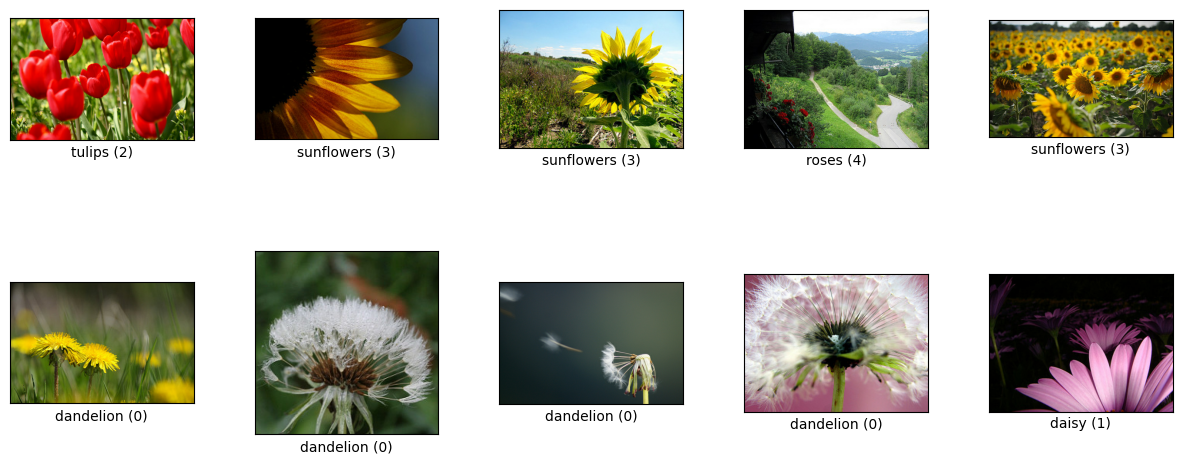

In [4]:
# looking at some images
fig = tfds.show_examples(train_ds, info, rows=2, cols=5, plot_scale=3)

In [5]:
# getting the number of classes in data
num_classes = info.features['label'].num_classes
print(num_classes)

5


In [6]:
# getting the class names in data
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

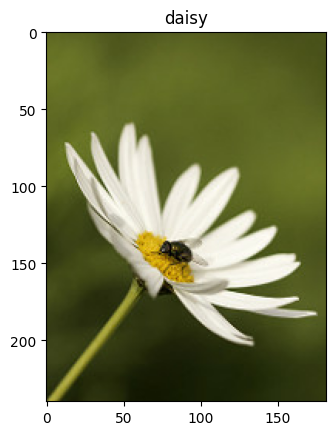

In [7]:
# fethcing an image for resizing & rescaling
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [8]:
# resizing & rescaling images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0/255)
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

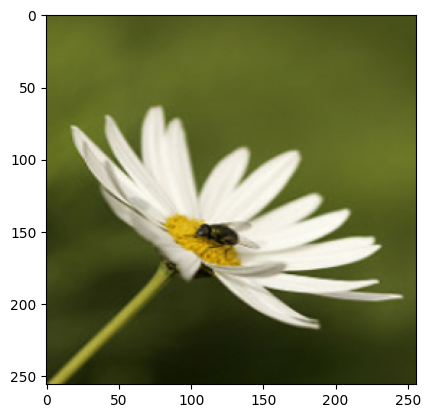

In [9]:
# checking the image
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [10]:
# checking the pixel values
print(f"Pixel values: minimum {result.numpy().min()} and maximum {result.numpy().max()}")

Pixel values: minimum 0.0 and maximum 0.9986664056777954


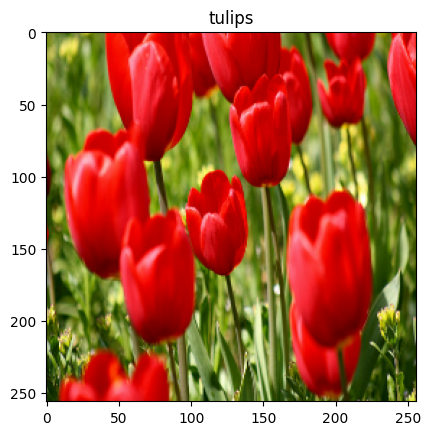

In [11]:
# fethcing an image for data augmentation
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [12]:
# using augmentation layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode="horizontal_and_vertical", seed=42),
  layers.RandomRotation(factor=0.2, seed=42)
])

In [13]:
# adding the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

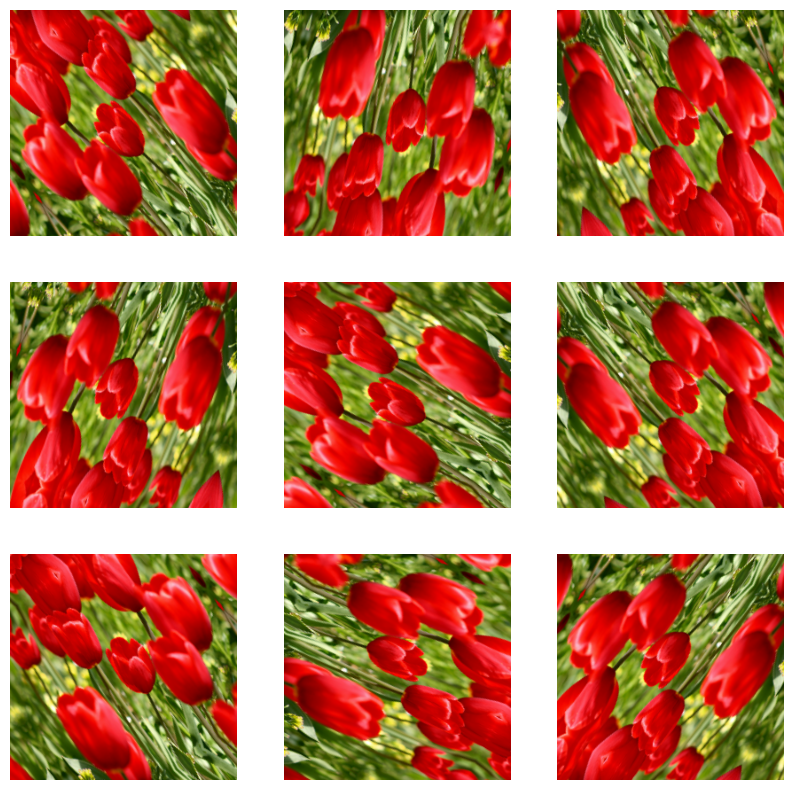

In [14]:
# checking the results
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [15]:
# apply augmentation on train set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
# building input pipelines
train_ds = train_ds.shuffle(len(train_ds)).batch(32).cache().prefetch(tf.data.AUTOTUNE) 
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
# model architecture
model = tf.keras.Sequential([
    layers.Conv2D(8, 3, padding='same', activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])

In [18]:
# getting model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 16)               

In [19]:
# model config
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [20]:
# model training
history = model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1)

Epoch 1/2
92/92 [==============================] - 38s 47ms/step - loss: 1.4712 - accuracy: 0.3661 - val_loss: 1.4095 - val_accuracy: 0.4142
Epoch 2/2
92/92 [==============================] - 2s 25ms/step - loss: 1.3383 - accuracy: 0.4384 - val_loss: 1.3121 - val_accuracy: 0.4687


In [21]:
# model evaluation
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Accuracy: {round(acc * 100, 2)}")

Accuracy: 48.5
